In [3]:
#
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
# 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import multiprocessing

import xgboost as xgb
xgb.set_config(verbosity=1)

#
import util.Util as util#, plot_accuracies
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

file_names = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [4]:

def plot_accuracies(accuracies: dict, title: str):
    """
    Plot a dictionary of accuracies on the format {"Computer vision": 0.99, (...) }
    """
    
    f, ax = plt.subplots(figsize=(18,4))

    plt.bar(range(len(accuracies)), list(accuracies.values()), align='center')
    plt.xticks(range(len(accuracies)), list(accuracies.keys()), rotation=90)
    plt.ylim([0,1.1])
    ax.set_title(title)

    for bars in ax.containers:
        ax.bar_label(bars)
    return f, ax

In [5]:
# Read GLOVE embeddings from file
glove_df = util.read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Read CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:15, 123477.58it/s]


In [6]:
# Read the cleaned dataframe
full_df = util.read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description'
vectorizer = TfidfVectorizer(max_features=250)
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col)

* Read CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)
Initializing DataFrameFeatures object


In [ ]:
id = dfc1.dff.documents('id')[0]
text = dfc1.dff.documents('description')[0]
nace = dfc1.dff.documents('NACE')[0]

In [19]:
# SHOULD GIVE HIGHER ACCURACY WHEN TRAINING AND TESTING ON THE SAME  # 0.55
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc2.get_feature_vectors(split=False)

# clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False, n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)
# clf.score(X_train, y_train)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

xgclassifier = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective ='binary:logistic', eval_metric='map', n_jobs=multiprocessing.cpu_count() // 2))

_ = classifier.fit(X_train, y_train)

* Read CSV from path: data/train/Computer vision.csv. Size: (201, 3)
Initializing DataFrameFeatures object
* Read CSV from path: data/train/Consulting.csv. Size: (182, 3)
Initializing DataFrameFeatures object


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='map',
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=4, num_parallel_tree=1,
                              objective='binary:logistic', predictor='auto',
            

In [21]:
from sklearn.metrics import average_precision_score

preds = classifier.predict(X_test)
average_precision_score(y_test, preds)

0.8245826447117138

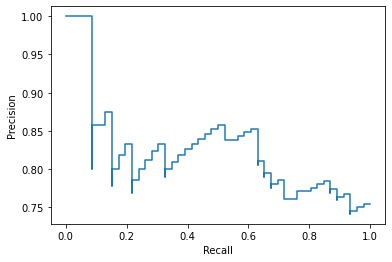

In [23]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


In [ ]:
clf.coef_

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc2.get_feature_vectors(split=False)


In [ ]:
dfc1.dff.overlapping_words_rank(text)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

np.array([cosine_similarity([x],query_vector)[0][0] for x in dfc1.dff.fitted_vectorizer.toarray()])

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train = dfc1.dff.fitted_vectorizer.toarray()
_, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test = dfc2.dff.fitted_vectorizer.toarray()
_, y_test = dfc2.get_feature_vectors(split=False)

xg_reg = xgb.XGBRegressor(objective ='rank:map', eval_metric='map', n_jobs=multiprocessing.cpu_count() // 2)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))
print(score)
preds = xg_reg.predict(X_train)
score = np.sqrt(mean_squared_error(y_train, preds))
score

In [1]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train = dfc1.dff.fitted_vectorizer.toarray()
_, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test = dfc2.dff.fitted_vectorizer.toarray()
_, y_test = dfc2.get_feature_vectors(split=False)

clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False, n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

NameError: name 'DataFrameClassifier' is not defined

In [ ]:
from sklearn.metrics import average_precision_score

average_precision_score()